# 2. Potential flow with an impenetrable surface

This part introduces the treatment of rigid impenetrable surfaces in `GridPotentialFlow`. We can impose the no-penetration constraint by setting the fluid streamfunction equal to that of the surface $\mathfrak{s}_b$, up to a uniform value $s_0$. The discrete no-penetration constraint is thus

$\mathsf{Es}=\mathfrak{s}_{b}-\mathsf{E} \mathsf{s}_{\infty}-\mathfrak{s}_{0},$

where $\mathsf{E}$ is the interpolation operator that interpolates grid data to the surface points, \mathsf{s}_{\infty} is the streamfunction of the uniform flow. For a body translating at velocity $(U,V)$ and rotating at angular velocity $\Omega$, this streamfunction would be

$\mathfrak{s}_{b,k} = U \mathfrak{r}_y - V \mathfrak{r}_x - \frac{1}{2} \Omega (\mathfrak{r}_x^2+\mathfrak{r}_y^2).$

For later shorthand, we will denote the difference between the body motion streamfunction and interpolated uniform flow streamfunction by $\mathfrak{s}'_b \equiv \mathfrak{s}_b - \mathsf{E} \mathsf{s}_{\infty}$. The no-penetration constraint is enforced in the basic potential flow problem with the help of a vector of Lagrange multipliers, $\mathfrak{f}$, on the surface points. The modified potential flow problem is thus

$\mathsf{Ls} + \mathsf{R}\mathfrak{f} = -\mathsf{w},$

where $\mathsf{R}$ is the regularization operator that transfers data from surface data to nodes. that $\mathsf{E}$ can be constructed (and we will assume it has) so that it is the transpose of the interpolation operator, $\mathsf{E} = \mathsf{R}^{T}$.

From the previous equation, it is clear (by simple comparison with the vorticity on the right-hand side) that the vector $\mathfrak{f}$ represents the strength of the discrete bound vortex sheet on the surface. Suppose we consider the bound vortex sheet $\gamma(s)$ that emerges from the analogous continuous problem on the undiscretized surface, where $s$ is the arc-length parameter along the surface. At each point $p$, the discrete solution $\mathfrak{f}$ is approximately equal to this continuous solution, multiplied by the length $\delta S_p$ of the small segment surrounding the point:

$\mathfrak{e}_{p}^{T} \mathfrak{f} \approx \gamma(s) \delta S_p.$

Thus, the potential flow problem in the presence of the impenetrable surface is

$\begin{bmatrix}
\mathsf{L} & \mathsf{R} \\
\mathsf{E} &  0
\end{bmatrix} \begin{pmatrix} \mathsf{s} \\ \mathfrak{f} \end{pmatrix} =
\begin{pmatrix} -\mathsf{w} \\ \mathfrak{s}'_b - \mathfrak{s}_0 \end{pmatrix}.$

This problem has the structure of a generic saddle-point problem and we will encounter many such systems in this work. `GridPotentialFlow.jl` will automatically formulate the no-penetration constraint on the streamfunction and solve the saddle system when it needs to. See the next page for the role of $\mathfrak{s}_0$ and how it will be treated internally.

We will now consider two examples. In these examples, we use the following grid.

In [1]:
using GridPotentialFlow
using Plots
Δx = 0.03
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);

## Vortex near a cylinder

As an basic example, consider now a point vortex near a circular cylinder.

`GridPotentialFlow.jl` works with bodies from `RigidBodyTools.jl`. For our circular cylinder, we use the `Circle` constructor.

In [2]:
Rc = Lx/4
circle = Circle(Rc,2*cellsize(g))
Δs = dlength(circle);

We choose an initial position $R_v$ of the vortex at $3/2 R_c$ from the origin.

In [3]:
Rv = 3/2*Rc
vortex = Vortex(Rv,0.0,1.0);

We construct the `VortexModel` by using the optional `bodies` keyword. In this case, we are interested in the bound vortex sheet strength $\mathfrak{f}$, instead of just the streamfunction field. For this reason, we use `solvesystem`, which in this case returns an `UnregularizedPotentialFlowSolution`.

In [4]:
model = VortexModel(g,vortices=[vortex],bodies=[circle]);
w = computew(model)
sol = solvesystem(model,w);

Analytical solution (vortex at Rv and image vortex at Rc^2/Rv)

In [5]:
r1 = sqrt.((circle.x.-Rv).^2 .+ (circle.y).^2) # distance from vortex to points on circle
r2 = sqrt.((circle.x.-Rc^2/Rv).^2 .+ (circle.y).^2) # distance from image vortex to points on circle
θ1 = π.+atan.((circle.y)./(circle.x.-Rv)) # angle from vortex to points on circle
θ2 = atan.((circle.y),(circle.x.-Rc^2/Rv)) # angle from image vortex to points on circle
v1x = -vortex.Γ./(2π*r1).*cos.(θ1.-π/2) # x velocity on circle induced by vortex
v1y = -vortex.Γ./(2π*r1).*sin.(θ1.-π/2) # y velocity on circle induced by vortex
v2x = vortex.Γ./(2π*r2).*cos.(θ2.-π/2) # x velocity on circle induced by image vortex
v2y = vortex.Γ./(2π*r2).*sin.(θ2.-π/2) # y velocity on circle induced by image vortex
v = sqrt.((v1x.+v2x).^2+(v1y.+v2y).^2) # velocity magnitude on circle
γ = -v; # bound vortex sheet strength on circle (velocity on circle is clockwise if positive vortex is to the right of it)

We can then easily retrieve the streamfunction and the bound vortex sheet strength from the fields of the solution variable.

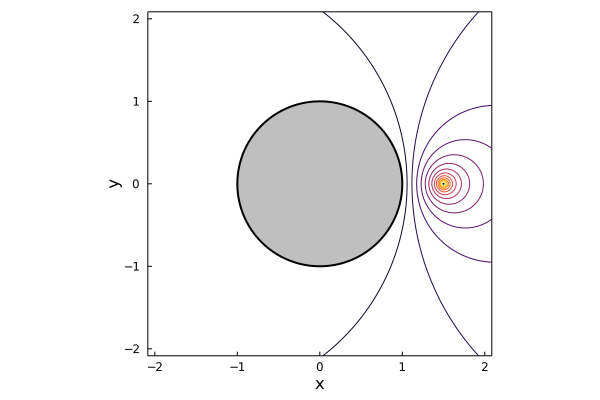

In [6]:
plot(sol.ψ,g)
plot!(circle,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2)
scatter!([vortex.x],[vortex.y],color=:black,markersize=2,xlabel="x",ylabel="y")

For this example, we can easily calculate the analytical bound vortex sheet strength $\gamma and compare it with our numerical solution $f$.

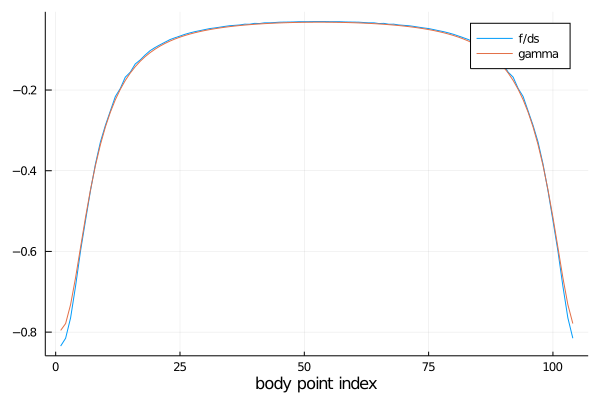

In [7]:
plot(sol.f./Δs,label="f/ds",xlabel="body point index")
plot!(γ,label="gamma")

## Moving cylinder

In this example we will create a model with a moving body.

Here we use the keyword `parameters` to solve our model with a `ModelParameters` variable, in which we enter a velocity for our body using the `Ub` keyword.

In [8]:
model = VortexModel(g,bodies=[circle]);
w = computew(model)
modelparameters = ModelParameters(Ub=[(1.0,0.0)])
sol = solvesystem(model,w,parameters=modelparameters);

# Analytical solution
θ = atan.(circle.y,circle.x)
γ = 2*sin.(θ);

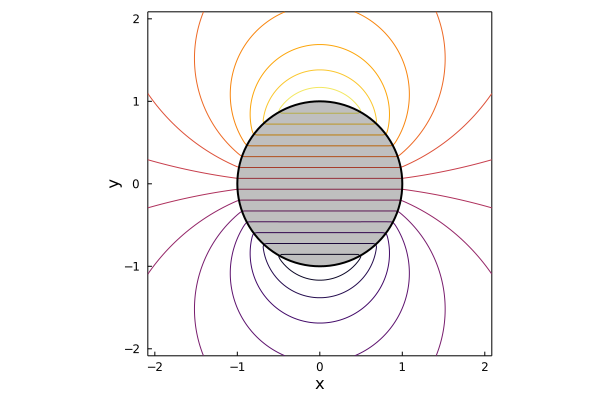

In [9]:
plot(sol.ψ,g)
plot!(circle,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2,xlabel="x",ylabel="y")

Again, we can compare the discrete bound vortex sheet strength with the analytical vortex sheet strength.

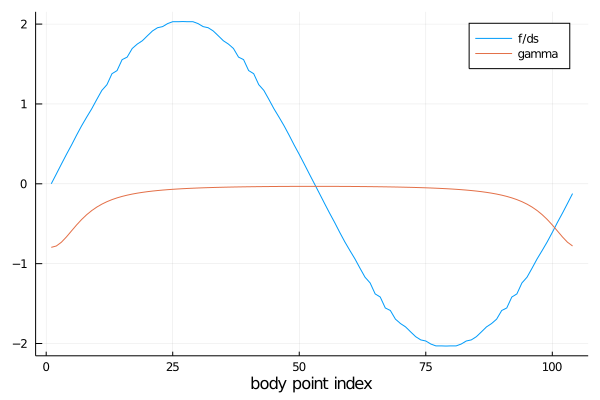

In [10]:
plot(sol.f./Δs,label="f/ds",xlabel="body point index")
plot!(γ,label="gamma")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*